## Score Model w/ Weather EDA

### Objective

* Evaluation of basic linear model using weather factors and previous scores

### Rationale

*  Why This?  Before establishing a baseline model, the performance implications of various model choices need to be explored.

*  Why Me?  Because I will be building the baseline model, I am the logical choice

*  Why Now?  Data from a reproducible pipeline is now available; understanding model choices is necessary before continuing on the project critical path of model implementation

### Requirements

*  Pandas 0.24.2
*  Scikit-learn 0.21.2
*  Matplotlib 3.1.0

### Input / Output

*  This notebook is expected to be in `models/notebooks/eda`

*  The input weather data is in a file `models/wx_model_data/wx_model.csv`

*  The input score data is in a file `models/score_model_data/scores.csv`

*  The output models are stored in a file `models/score_model_data/linear_model_fits.csv`

### Import / Set-Up

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get weather data
wx_df = pd.read_csv('../../wx_model_data/wx_model.csv', parse_dates = ['date'])
# Get scores data
scores_df = pd.read_csv('../../score_model_data/scores.csv', parse_dates = ['time'])

In [3]:
wx_df.head()

,Unnamed: 0,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var,course_id
0,0,2018-11-25,57.023188,80.344928,1.289855,6.800000,88.214493,0.000000,0.807230,0.670447,0.560000,266.490351,154.904818,0
1,1,2019-02-24,52.839273,179.611525,1.979019,11.066667,75.883806,0.000000,-0.276422,-1.255324,0.062222,1907.347412,27.922180,0
2,2,2019-01-27,56.642593,66.362963,3.916667,12.466667,73.714815,0.000000,2.674324,2.326601,1.582222,301.056529,227.954035,0
3,3,2019-02-17,49.299471,267.369841,5.489524,14.066667,67.711164,0.000778,-4.882030,-0.070813,1.528889,14.666560,13.316158,0
4,4,2019-01-06,51.505556,153.133333,4.384722,20.933333,89.798611,0.105625,0.829178,-3.227827,6.995556,214.376551,906.500313,0


In [4]:
scores_df.head()

,Unnamed: 0,Name,Raw,Handicap,Adjusted,time,course_id
0,0,Mark Shannon,61.0,-12.40,48.60,2019-01-19 08:00:00,1
1,1,Jacob Kermish-Wells,60.0,-10.72,49.28,2019-01-19 08:00:00,1
2,2,Luiz Celeste,55.0,-5.23,49.77,2019-01-19 08:00:00,1
3,3,Tu Tran,59.0,-9.07,49.93,2019-01-19 08:00:00,1
4,4,Matty Angell,53.0,-1.50,51.50,2019-01-19 08:00:00,1


In [5]:
# Clean out duplicated indexes
wx_df = wx_df.drop(columns = 'Unnamed: 0')
scores_df = scores_df.drop(columns = 'Unnamed: 0')

In [6]:
# Sort prior to merge
wx_df = wx_df.sort_values(by = ['date','course_id'])
scores_df = scores_df.sort_values(by= ['time','course_id','Name'])

In [7]:
all_df = pd.merge_asof(scores_df, wx_df, by = 'course_id', left_on= 'time', right_on = 'date',
                       direction = 'backward', tolerance = pd.Timedelta('1d') )
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
0,Alex Torres,68.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Andy Leaf,53.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Anthony McGinnis,78.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aurelius Lewicki,57.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Billy Manger,58.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop any rows that do not have weather data
all_df = all_df.dropna(subset = ['weighted_T'])
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
478,Ben Horst,65.0,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
479,Bob Montes,54.0,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
480,Dennis Warsen,52.0,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
481,Gonzalo Arestizabal,63.0,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
482,Greg Mann,58.0,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685


In [9]:
len(all_df)

2960

In [10]:
all_df.columns

Index(['Name', 'Raw', 'Handicap', 'Adjusted', 'time', 'course_id', 'date',
       'weighted_T', 'weighted_w_dir', 'weighted_w_spd', 'weighted_w_gust',
       'weighted_rh', 'weighted_precip', 'weighted_w_u', 'weighted_w_v',
       'w_gust_var', 'w_dir_var', 'w_uv_var'],
      dtype='object')

In [29]:
def model_player_performance(player : str, course : int):
    """Given a player name and course id, return model parameters indicating the effects of weather on expected score.
    The model will return a dictionary with coefficients for easy identification"""
    
    model_dict = {}
    model_dict['player'] = player
    model_dict['course_id'] = course
    player_df = all_df[(all_df['Name'] == player) & (all_df['course_id'] == course)]
    # Replace index with the cumulative number of games played, and make that into a column
    player_df = player_df.reset_index()
    player_df = player_df.drop(columns = ['index'])
    player_df = player_df.reset_index()
    
    #Build weather model
    X = player_df[['index','weighted_T', 'weighted_w_dir', 'weighted_w_spd', 'weighted_w_gust',
        'weighted_precip', 'weighted_w_u', 'weighted_w_v',
       'w_gust_var', 'w_dir_var', 'w_uv_var']].values
    y = player_df['Raw'].values
    
    if len(player_df) > 13:
        scaler = StandardScaler()
        lr = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], cv = 3, 
                          max_iter = 5000, random_state=42)
        pipeline = make_pipeline(scaler, lr)
        pipeline.fit(X,y)
        ypred = pipeline.predict(X)
        cumgame_coeff, T_coeff, wdir_coeff, wspd_coeff, wgust_coeff,\
        precip_coeff, u_coeff, v_coeff, gustvar_coeff, dirvar_coeff, uv_var_coeff = pipeline['elasticnetcv'].coef_
        model_dict['prediction_score'] = pipeline.score(X,y)
        model_dict['cumgame_coeff'] = cumgame_coeff
        model_dict['T_coeff'] = T_coeff
        model_dict['wdir_coeff'] = wdir_coeff
        model_dict['wspd_coeff'] = wspd_coeff
        model_dict['wgust_coeff'] = wgust_coeff
        model_dict['precip_coeff'] = precip_coeff
        model_dict['u_coeff'] = u_coeff
        model_dict['v_coeff'] = v_coeff
        model_dict['gustvar_coeff'] = gustvar_coeff
        model_dict['dirvar_coeff'] = dirvar_coeff
        model_dict['uv_var_coeff'] = uv_var_coeff
        model_dict['intercept'] = pipeline['elasticnetcv'].intercept_
        model_dict['mse'] = mean_squared_error(y, ypred)
        model_dict['n_value'] = len(player_df)
    elif len(player_df) > 0:
        model_dict['nomatch'] = 1
    else:
        model_dict['nomatch'] = 1
        
    return model_dict    

In [30]:
#Make list of player names
player_names = all_df['Name'].unique()
perf_dicts = []
for player_name in player_names:
    for course_id in range(all_df['course_id'].max() + 1):
        perf_dict = model_player_performance(player_name, course_id)
        perf_dicts.append(perf_dict)
            
perf_model_df = pd.DataFrame(perf_dicts)
perf_model_df.head()

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01121810991049621, tolerance: 0.009222222222222224
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01707703687829465, tolerance: 0.009222222222222224
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023136391763770803, tolerance: 0.009222222222222224
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not conv

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03244667182098837, tolerance: 0.012854545454545457
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01195325066121633, tolerance: 0.01101
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013858231792234221, tolerance: 0.01101
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016304184825858048, tolerance: 0.016
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016214257638042184, tolerance: 0.016
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018631588874429728, tolerance: 0.016
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,gustvar_coeff,intercept,mse,n_value,nomatch,player,precip_coeff,prediction_score,u_coeff,uv_var_coeff,v_coeff,wdir_coeff,wgust_coeff,wspd_coeff
0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Ben Horst,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Ben Horst,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Ben Horst,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Bob Montes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Bob Montes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
perf_model_small = perf_model_df.dropna(subset=['T_coeff'])
print(len(perf_model_small))
perf_model_small.head()

45


,T_coeff,course_id,cumgame_coeff,dirvar_coeff,gustvar_coeff,intercept,mse,n_value,nomatch,player,precip_coeff,prediction_score,u_coeff,uv_var_coeff,v_coeff,wdir_coeff,wgust_coeff,wspd_coeff
5,-0.303161,2,-0.000000,0.000000,0.000000,55.043478,9.368340,23.0,NaN,Bob Montes,0.152295,0.328657,-0.000000,0.000000,-0.706347,-0.000000,0.982209,0.000000
7,-2.212886,1,-0.000000,0.000000,-0.000000,57.142857,6.708201,14.0,NaN,Dennis Warsen,0.013266,0.583922,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
8,-0.000000,2,-0.000000,-0.000000,0.000000,54.358491,14.013276,53.0,NaN,Dennis Warsen,0.000000,0.120216,-0.000000,-0.000000,-0.000000,0.000000,0.797097,0.000000
11,-0.363872,2,-0.100533,-0.029896,-0.000000,63.142857,6.180790,21.0,NaN,Gonzalo Arestizabal,0.000000,0.256484,-0.139923,-0.305617,-0.223741,0.143666,0.066997,0.102911
20,-0.465969,2,-0.814821,-0.032315,-0.236957,56.458333,8.637850,24.0,NaN,Jon Braidman,0.000000,0.473781,0.536920,-0.247028,-0.357186,-0.188228,1.353104,-0.000000


(array([18.,  2., 25.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

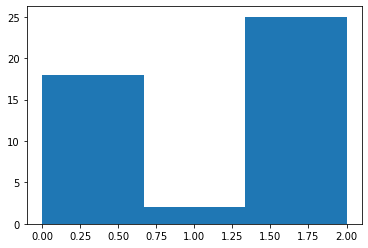

In [32]:
plt.hist(perf_model_small['course_id'],bins=3)

(array([ 1.,  1.,  0.,  0.,  1.,  2.,  4., 32.,  2.,  2.]),
 array([-2.21288634, -1.90381296, -1.59473958, -1.2856662 , -0.97659283,
        -0.66751945, -0.35844607, -0.04937269,  0.25970069,  0.56877406,
         0.87784744]),
 <a list of 10 Patch objects>)

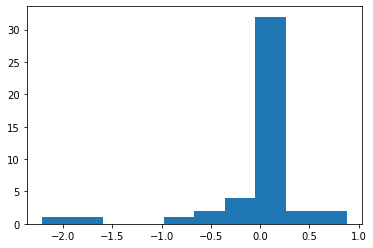

In [33]:
plt.hist(perf_model_small['T_coeff'])

(array([2., 7., 6., 8., 7., 8., 4., 1., 1., 1.]),
 array([ 2.52839953,  4.52709019,  6.52578085,  8.52447151, 10.52316217,
        12.52185283, 14.52054349, 16.51923415, 18.5179248 , 20.51661546,
        22.51530612]),
 <a list of 10 Patch objects>)

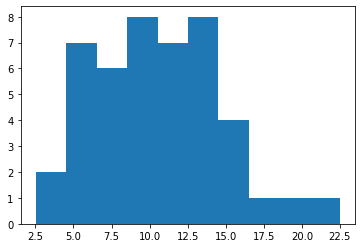

In [34]:
plt.hist(perf_model_small['mse'])

In [35]:
perf_model_df.to_csv('../../score_model_data/score_model2_X_rh_n13.csv')
len(perf_model_df)

1419

(array([ 1.,  0.,  0.,  1.,  2., 34.,  4.,  2.,  0.,  1.]),
 array([-2.78523724, -2.31008506, -1.83493288, -1.3597807 , -0.88462852,
        -0.40947633,  0.06567585,  0.54082803,  1.01598021,  1.49113239,
         1.96628458]),
 <a list of 10 Patch objects>)

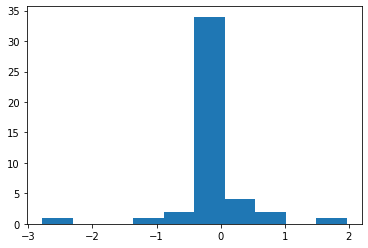

In [36]:
plt.hist(perf_model_small['cumgame_coeff'])

In [37]:
perf_model_small.prediction_score.value_counts().sort_index().head(5)

0.000000    14
0.009530     1
0.040065     1
0.075782     1
0.084620     1
Name: prediction_score, dtype: int64

In [34]:
perf_model_small.columns

Index(['T_coeff', 'course_id', 'cumgame_coeff', 'dirvar_coeff',
       'gustvar_coeff', 'intercept', 'mse', 'n_value', 'nomatch', 'player',
       'precip_coeff', 'prediction_score', 'rh_coeff', 'u_coeff',
       'uv_var_coeff', 'v_coeff', 'wdir_coeff', 'wgust_coeff', 'wspd_coeff'],
      dtype='object')

(array([16.,  4.,  5.,  4.,  3.,  2.,  2.,  1.,  6.,  2.]),
 array([0.        , 0.07275419, 0.14550838, 0.21826257, 0.29101676,
        0.36377094, 0.43652513, 0.50927932, 0.58203351, 0.6547877 ,
        0.72754189]),
 <a list of 10 Patch objects>)

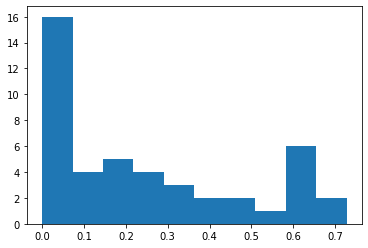

In [38]:
plt.hist(perf_model_small['prediction_score'])

In [39]:
zeros = []
coeff_count = []
for row in perf_model_small.iterrows():
    tmp_count = 0
    if row[1]['cumgame_coeff'] == 0:
        tmp_count += 1
    if row[1]['T_coeff'] == 0:
        tmp_count += 1
    if row[1]['precip_coeff'] == 0:
        tmp_count += 1
    if row[1]['u_coeff'] == 0:
        tmp_count += 1
    if row[1]['v_coeff'] == 0:
        tmp_count += 1
    if row[1]['wdir_coeff'] == 0:
        tmp_count += 1
    if row[1]['wgust_coeff'] == 0:
        tmp_count += 1
    if row[1]['wspd_coeff'] == 0:
        tmp_count += 1
    if row[1]['dirvar_coeff'] == 0:
        tmp_count += 1
    if row[1]['gustvar_coeff'] == 0:
        tmp_count += 1
    if row[1]['uv_var_coeff'] == 0:
        tmp_count += 1
    zeros.append(tmp_count)
    coeff_count.append(11 - tmp_count)
perf_model_small['coeff_count'] = coeff_count
perf_model_small.head()

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,T_coeff,course_id,cumgame_coeff,dirvar_coeff,gustvar_coeff,intercept,mse,n_value,nomatch,player,precip_coeff,prediction_score,u_coeff,uv_var_coeff,v_coeff,wdir_coeff,wgust_coeff,wspd_coeff,coeff_count
5,-0.303161,2,-0.000000,0.000000,0.000000,55.043478,9.368340,23.0,NaN,Bob Montes,0.152295,0.328657,-0.000000,0.000000,-0.706347,-0.000000,0.982209,0.000000,4
7,-2.212886,1,-0.000000,0.000000,-0.000000,57.142857,6.708201,14.0,NaN,Dennis Warsen,0.013266,0.583922,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,2
8,-0.000000,2,-0.000000,-0.000000,0.000000,54.358491,14.013276,53.0,NaN,Dennis Warsen,0.000000,0.120216,-0.000000,-0.000000,-0.000000,0.000000,0.797097,0.000000,1
11,-0.363872,2,-0.100533,-0.029896,-0.000000,63.142857,6.180790,21.0,NaN,Gonzalo Arestizabal,0.000000,0.256484,-0.139923,-0.305617,-0.223741,0.143666,0.066997,0.102911,9
20,-0.465969,2,-0.814821,-0.032315,-0.236957,56.458333,8.637850,24.0,NaN,Jon Braidman,0.000000,0.473781,0.536920,-0.247028,-0.357186,-0.188228,1.353104,-0.000000,9


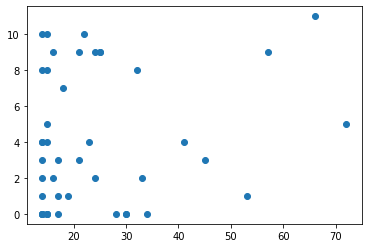

In [40]:
plt.scatter(x=perf_model_small.n_value, y=perf_model_small.coeff_count)

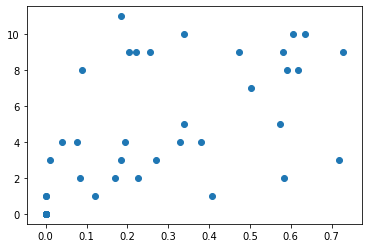

In [46]:
plt.scatter(x=perf_model_small.prediction_score, y=perf_model_small.coeff_count)

In [41]:
perf_model_small.mse.mean()

10.496456344755513

In [42]:
perf_model_small.mean()

T_coeff             -0.076904
course_id            1.155556
cumgame_coeff       -0.024371
dirvar_coeff         0.044052
gustvar_coeff       -0.031759
intercept           57.175515
mse                 10.496456
n_value             24.111111
nomatch                   NaN
precip_coeff         0.185389
prediction_score     0.238531
u_coeff             -0.062268
uv_var_coeff        -0.088330
v_coeff              0.042376
wdir_coeff           0.010105
wgust_coeff          0.175829
wspd_coeff           0.136459
coeff_count          4.000000
dtype: float64

In [28]:
perf_model_small.std()

T_coeff              0.444488
course_id            0.981484
cumgame_coeff        0.597652
dirvar_coeff         0.398663
gustvar_coeff        0.138713
intercept            4.048949
mse                  4.665364
n_value             13.604621
nomatch                   NaN
precip_coeff         0.361824
prediction_score     0.263558
u_coeff              0.387526
uv_var_coeff         0.277781
v_coeff              0.646197
wdir_coeff           0.305849
wgust_coeff          0.408886
wspd_coeff           0.389128
coeff_count          3.770528
dtype: float64

In [43]:
perf_model_small[['player','course_id','mse','coeff_count']].sort_values(by='mse')

,player,course_id,mse,coeff_count
720,Niel Jones,0,2.528400,10
111,Chris Isom,0,4.128068,3
461,Christian Eck,2,4.847626,9
86,Peter Sontag,2,5.269297,9
71,Conner Russell,2,6.084604,10
26,Matt Rowe,2,6.089419,5
182,Luiz Celeste,2,6.156030,3
11,Gonzalo Arestizabal,2,6.180790,9
690,Matt Duncanson,0,6.514368,4
552,Alan Chambless,0,6.555788,4


In [44]:
perf_model_small.loc[perf_model_small['player'] == 'Sean Saxton']

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,gustvar_coeff,intercept,mse,n_value,nomatch,player,precip_coeff,prediction_score,u_coeff,uv_var_coeff,v_coeff,wdir_coeff,wgust_coeff,wspd_coeff,coeff_count
747,0.795462,0,-0.011504,1.218429,0.0,56.785714,8.717551,14.0,NaN,Sean Saxton,0.845591,0.619032,-0.0,-0.625112,2.524385,1.552971,0.0,1.343955,8
